# Data-Intensive Applications on HPC Using Hadoop, Spark and RADICAL-Cybertools

Shantenu Jha and Andre Luckow








## 1. Pilot-Abstraction for distributed HPC and Apache Hadoop Big Data Stack (ABDS)

The Pilot-Abstraction has been successfully used in HPC for supporting a diverse set of task-based workloads on distributed resources. A Pilot-Job is a placeholder job that is submitting to the resource management system and is used as a container for a dynamically determined set of compute tasks. The Pilot-Data abstraction extends the Pilot-Abstraction for supporting the management of data in conjunction with compute tasks. 

### 1.1 Pilot-Abstraction

The Pilot-Abstraction supports a heterogeneous resources, in particular different kinds of cloud, HPC and Hadoop resources.

![Pilot Abstraction](figures/interoperable_pilot_job.png)

### 1.2 Example

The following example demonstrates how the Pilot-Abstraction is used to manage a set of compute tasks.


In [33]:
%pylab inline
import sys
import os
import time

from pilot import PilotComputeService, ComputeDataService, State
COORDINATION_URL = "redis://EiFEvdHRy3mNBZDjsypraXGNQqJcAYKaTnHCZxgqLsykDoKXb@localhost:6379"

pilot_compute_service = PilotComputeService(coordination_url=COORDINATION_URL)

pilot_compute_description = {
                         "service_url": 'fork://localhost',
                         "number_of_processes": 1,                             
                        }

pilotjob = pilot_compute_service.create_pilot(pilot_compute_description=pilot_compute_description)

compute_unit_description = {
        "executable": "/bin/sleep",
        "arguments": ["0"],
        "number_of_processes": 1,            
        "output": "stdout.txt",
        "error": "stderr.txt",   
}   

compute_unit = pilotjob.submit_compute_unit(compute_unit_description)

compute_unit.wait()

# compute_unit_stats = pd.DataFrame(compute_unit.get_details(), index=[0])

compute_unit_stats = pd.DataFrame(compute_unit.get_details().values(), index=compute_unit.get_details().keys())

pilot_compute_service.cancel()

Populating the interactive namespace from numpy and matplotlib


In [34]:
compute_unit_stats

,0
run_host,radical-5
Executable,/bin/sleep
NumberOfProcesses,1
start_time,1440980773.78
agent_start_time,1440980773.9
state,Done
end_time,1440980779.13
Arguments,['0']
Error,stderr.txt
Output,stdout.txt


## 2. Pilot-Hadoop

For the purpose of this tutorial we setup a Hadoop cluster on [Chameleon](https://www.chameleoncloud.org/):

* YARN: http://129.114.108.119:8088/
* HDFS: http://129.114.108.123:50070/
* Ambari: http://129.114.108.119:8080/


## 3. Advanced Analytics


### 3.1 Setup Spark on YARN

In [ ]:
from numpy import array
from math import sqrt

%run env.py
%run util/init_spark.py

print "SPARK HOME: %s"%os.environ["SPARK_HOME"]

try:
    sc
except NameError:
    conf = SparkConf()
    conf.set("spark.num.executors", "4")
    conf.set("spark.executor.instances", "4")
    conf.set("spark.executor.memory", "5g")
    conf.set("spark.cores.max", "4")
    conf.setAppName("iPython Spark")
    conf.setMaster("yarn-client")
    sc = SparkContext(conf=conf)

In [ ]:
rdd = sc.parallelize(range(10))

In [ ]:
rdd.map(lambda a: a*a).collect()

### 3.2 KMeans (Scikit)

In [21]:
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

iris = datasets.load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)

Populating the interactive namespace from numpy and matplotlib


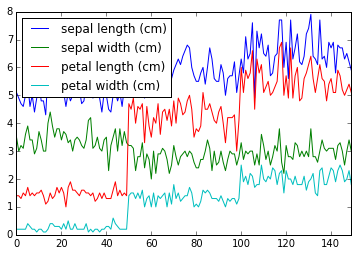

In [22]:
data.plot()

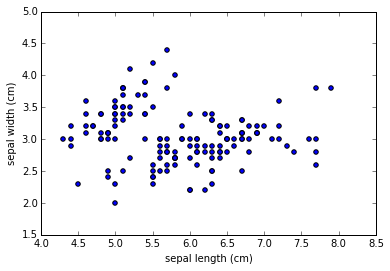

In [24]:
data.plot(kind='scatter', x='sepal length (cm)', y='sepal width (cm)');

### 3.2 KMeans (Spark)

https://spark.apache.org/docs/latest/mllib-clustering.html#k-means

In [ ]:
# Load and parse the data
from pyspark.mllib.clustering import KMeans, KMeansModel
data = sc.textFile("data_1000points.csv")
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
                        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

In [ ]:
# Save and load model
clusters.save(sc, "kmeans.model")
sameModel = KMeansModel.load(sc, "kmeans.model")

## Graph Analysis

## Future Work

Midas

In [35]:
!ls figures

hadoop-on-hpc-viceverse.pdf  pilot-abds.png
hadoop-on-hpc-viceverse.png  pilotabstraction-for-dataparallel-processing.png
interoperable_pilot_job.pdf  pilotdata-hadoop-architecture.png
interoperable_pilot_job.png
